In [1]:
import csv
import time
import datetime
import json
import sys
import pandas as pd
import numpy as np

# data read

In [2]:
def get_ID_list(txtPath):
    ID_lists = []
    with open(txtPath, 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip('\n')
        ID_lists.append(line.split(','))
    return ID_lists

def get_label_list(txtPath):
    label_list = []
    with open(txtPath, 'r') as f:
        lines = f.readlines()
    for line in lines:
        label_list.append(line.strip('\n').split(',')[1])
    return label_list

def get_timestamp(time_str):
    return time.mktime(datetime.datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%S.%fZ").timetuple())

def get_hashtag(tweet_object):
    if 'entities' in tweet_object.keys():
        if 'hashtags' in tweet_object['entities'].keys():
            hashtag_list = []
            for elem in tweet_object['entities']['hashtags']:
                hashtag_list.append(elem['tag'])
            return hashtag_list
    return None

In [3]:
ID_list = get_ID_list('covid_new.txt')
label_list = get_label_list('covid.predictions.txt')[1:]
assert len(ID_list)==len(label_list)

openTrainData = open('covid.json')
covid_dict = json.load(openTrainData)
openTrainData.close()

In [4]:
for row_index in range(len(ID_list)):
    for tweetid in ID_list[row_index]:
        covid_dict[tweetid]['label'] = label_list[row_index]
        covid_dict[tweetid]['timestamp'] = get_timestamp(covid_dict[tweetid]['created_at'])
        covid_dict[tweetid]['hashtags'] = get_hashtag(covid_dict[tweetid])

In [5]:
assert len(list(covid_dict.keys()))==201839

In [6]:
covid_df = pd.DataFrame.from_dict(covid_dict, orient='index',
                       columns=['text', 'lang','hashtags', 'timestamp', 'source', 'created_at', 'author_id', 'label'])
covid_df.head()

,text,lang,hashtags,timestamp,source,created_at,author_id,label
1272262651100434433,"According to the New York Times, Warner Bros. ...",en,[Tenet],1.592130e+09,Twitter for iPhone,2020-06-14T20:20:28.000Z,1011312260805996547,0
1287153210990395392,Hurricane Hanna has made landfall in Texas.\n\...,en,None,1.595680e+09,Sprout Social,2020-07-25T22:30:14.000Z,44513878,0
1287191952115605505,@TexasTribune Guess what the cause of death is...,en,None,1.595689e+09,Twitter for iPhone,2020-07-26T01:04:10.000Z,1266937699128217602,0
1266555444283179008,Monkeys on the loose in India with stolen coro...,en,None,1.590769e+09,SocialFlow,2020-05-30T02:22:04.000Z,1917731,0
1258212704961155073,@BelAkinyii Let's not play blind that the work...,en,None,1.588780e+09,Twitter Web App,2020-05-07T01:50:59.000Z,1170754239272050688,0


In [7]:
covid_df.info

<bound method DataFrame.info of                                                                   text lang  \
1272262651100434433  According to the New York Times, Warner Bros. ...   en   
1287153210990395392  Hurricane Hanna has made landfall in Texas.\n\...   en   
1287191952115605505  @TexasTribune Guess what the cause of death is...   en   
1266555444283179008  Monkeys on the loose in India with stolen coro...   en   
1258212704961155073  @BelAkinyii Let's not play blind that the work...   en   
...                                                                ...  ...   
1265875761111666688  @seanhannity Trump total meltdown Coronavirus ...   en   
1265822646215872514  @seanhannity New York Post- January 5, 2020 " ...   en   
1265936765988286465  @seanhannity Everything was fine before COVID-...   en   
1265825373868228608  @seanhannity Sad to say, NY and NYC are train ...   en   
1265813858318454785  @seanhannity Breaking News: What Fox News won'...   en   

                   

In [8]:
covid_en_df = covid_df[covid_df.lang=='en']

In [9]:
covid_en_df.info

<bound method DataFrame.info of                                                                   text lang  \
1272262651100434433  According to the New York Times, Warner Bros. ...   en   
1287153210990395392  Hurricane Hanna has made landfall in Texas.\n\...   en   
1287191952115605505  @TexasTribune Guess what the cause of death is...   en   
1266555444283179008  Monkeys on the loose in India with stolen coro...   en   
1258212704961155073  @BelAkinyii Let's not play blind that the work...   en   
...                                                                ...  ...   
1265875761111666688  @seanhannity Trump total meltdown Coronavirus ...   en   
1265822646215872514  @seanhannity New York Post- January 5, 2020 " ...   en   
1265936765988286465  @seanhannity Everything was fine before COVID-...   en   
1265825373868228608  @seanhannity Sad to say, NY and NYC are train ...   en   
1265813858318454785  @seanhannity Breaking News: What Fox News won'...   en   

                   

# tweets normalization

In [10]:
covid_en_df.iloc[1]['text']

'Hurricane Hanna has made landfall in Texas.\n\nThe storm is hitting a section of the Texas coast already reeling from thousands of coronavirus cases. https://t.co/KWL3awKW00'

In [11]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer

In [12]:
tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return normTweet.split()

In [13]:
normalizeTweet(covid_en_df.iloc[1]['text'])

['Hurricane',
 'Hanna',
 'has',
 'made',
 'landfall',
 'in',
 'Texas',
 '.',
 'The',
 'storm',
 'is',
 'hitting',
 'a',
 'section',
 'of',
 'the',
 'Texas',
 'coast',
 'already',
 'reeling',
 'from',
 'thousands',
 'of',
 'coronavirus',
 'cases',
 '.',
 'HTTPURL']

# rumor/norumor split

In [14]:
covid_rm = covid_en_df[covid_en_df.label=='1']
covid_nr = covid_en_df[covid_en_df.label=='0']
print(f'rumor number: {len(covid_rm)}, no rumor number: {len(covid_nr)}')

rumor number: 35895, no rumor number: 165595


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter, defaultdict
from copy import deepcopy
from nltk.stem import WordNetLemmatizer

In [16]:
hashtag_list = covid_en_df["hashtags"].values.tolist()
rumor_hashtag_list = covid_en_df.loc[covid_en_df["label"] == '1']["hashtags"].values.tolist()
norumor_hashtag_list = covid_en_df.loc[covid_en_df["label"] == '0']["hashtags"].values.tolist()

In [17]:
def to_hashtag_dict(list):
    
    lemmatizer = WordNetLemmatizer()
    hashtagdict = defaultdict(int)
    for row in list:
        if not row is None:
            for hashtag in row:
                hashtagdict[lemmatizer.lemmatize(hashtag.lower())]+=1
    return hashtagdict

HASHTAGS_POPLIST = ['covid19', 'coronavirus', 'coronaviruspandemic', 'covid_19', 'covid', 
                   'pandemic', 'corona', 'covid19pandemic', 'covidー19', 'covid__19', 'covid2019']

def pop_hashtag(dict1, poplist=HASHTAGS_POPLIST):
    tdict = deepcopy(dict1)
    for k in dict1.keys():
        if k in HASHTAGS_POPLIST:
            tdict.pop(k)
    return tdict

In [18]:
hashtag_dict = to_hashtag_dict(hashtag_list)
rumor_hashtag_dict = to_hashtag_dict(rumor_hashtag_list)
norumor_hashtag_dict = to_hashtag_dict(norumor_hashtag_list)

hashtag_dict = pop_hashtag(hashtag_dict)
rumor_hashtag_dict = pop_hashtag(rumor_hashtag_dict)
norumor_hashtag_dict = pop_hashtag(norumor_hashtag_dict)

hashtag_sorted = [[item[0], item[1]] for item in sorted(hashtag_dict.items(), key=lambda item: item[1], reverse=True)] 
rumor_hashtag_sorted = [[item[0], item[1]] for item in sorted(rumor_hashtag_dict.items(), key=lambda item: item[1], reverse=True)] 
norumor_hashtag_sorted = [[item[0], item[1]] for item in sorted(norumor_hashtag_dict.items(), key=lambda item: item[1], reverse=True)]


## frequency

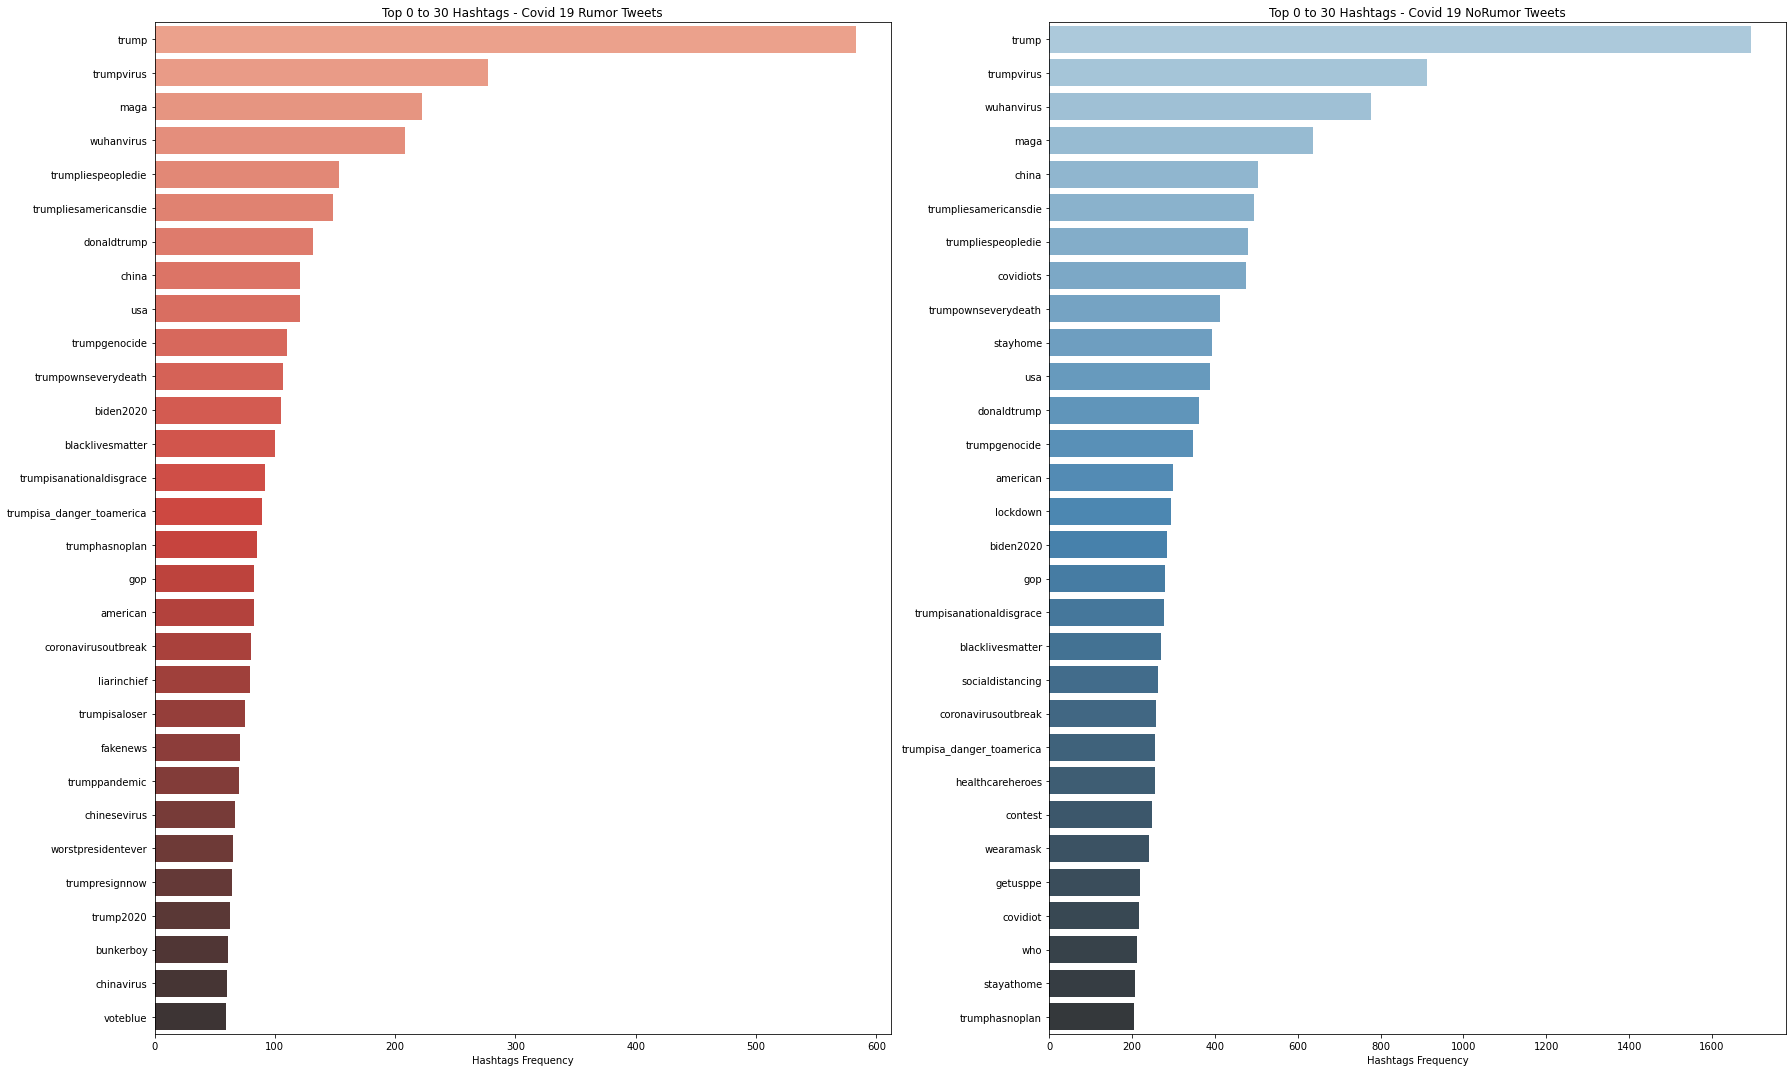

In [19]:
fig, ax = plt.subplots(1,2, figsize=(25,15))
START_INDEX = 0
END_INDEX = 30

sns.barplot(y=[i[0] for i in rumor_hashtag_sorted][START_INDEX:END_INDEX], 
            x=[i[1] for i in rumor_hashtag_sorted][START_INDEX:END_INDEX], 
            orient='h', ax=ax[0], palette="Reds_d")

sns.barplot(y=[i[0] for i in norumor_hashtag_sorted][START_INDEX:END_INDEX], 
            x=[i[1] for i in norumor_hashtag_sorted][START_INDEX:END_INDEX], 
            orient='h', ax=ax[1], palette="Blues_d")

ax[0].set_title(f"Top {START_INDEX} to {END_INDEX} Hashtags - Covid 19 Rumor Tweets")
ax[0].set_xlabel("Hashtags Frequency")
ax[1].set_title(f"Top {START_INDEX} to {END_INDEX} Hashtags - Covid 19 NoRumor Tweets")
ax[1].set_xlabel("Hashtags Frequency")
plt.tight_layout()
plt.show()

## Proportion

判断标准是自己定义的，所以没有统计学依据，可以忽略这种方法，直接用3.3的卡方检验

In [20]:
FREQ_THRESHOLD=200
def pop_less(dict1, threhold=FREQ_THRESHOLD):
    tdict = deepcopy(dict1)
    for k,v in dict1.items():
        if v < threhold:
            tdict.pop(k)
    return tdict

def get_proprotion_dict(dict1):
    allnum = sum(dict1.values())
    tdict = defaultdict(float)
    for k, v in dict1.items():
        tdict[k]=v/allnum
    return tdict

def pop_except_list(dict1, poplist):
    tdict = defaultdict(int)
    for k in poplist:
        if k in dict1:
            tdict[k] = dict1[k]
        else:
            tdict[k] = 0
    return tdict

HASHTAGS_POPLIST = ['covid19', 'coronavirus', 'coronaviruspandemic', 'covid_19', 'covid', 
                   'pandemic', 'corona', 'covid19pandemic', 'covidー19']

def pop_hashtag(dict1, poplist=HASHTAGS_POPLIST):
    tdict = deepcopy(dict1)
    for k in dict1.keys():
        if k in HASHTAGS_POPLIST:
            tdict.pop(k)
    return tdict

In [21]:
hashtag_proportion = get_proprotion_dict(pop_less(hashtag_dict))
rumor_hashtag_proportion = get_proprotion_dict(pop_except_list(rumor_hashtag_dict, list(hashtag_proportion.keys())))
norumor_hashtag_proportion = get_proprotion_dict(pop_except_list(norumor_hashtag_dict, list(hashtag_proportion.keys())))

assert len(list(rumor_hashtag_proportion.keys())) == len(list(hashtag_proportion.keys()))
assert len(list(norumor_hashtag_proportion.keys())) == len(list(hashtag_proportion.keys()))

In [43]:
DIFF_THRESHOLD = 0.1
def proportion_diff(dict1, dict2, alldict, 
                    dict3=rumor_hashtag_dict, dict4=norumor_hashtag_dict, 
                    dict5=hashtag_dict,
                    threshold=DIFF_THRESHOLD):
    rdict = defaultdict(float)
    for k in dict1.keys():
        diff = (dict1[k]-dict2[k])/alldict[k]
#         diff = (dict1[k]-alldict[k])**2/alldict[k] + (dict2[k]-alldict[k])**2/alldict[k]
        if diff>threshold:
            rdict[k] = dict1[k]/alldict[k]-1
        elif -diff>threshold:
            rdict[k] = -dict2[k]/alldict[k]+1
    return rdict

In [44]:
pdiff = proportion_diff(rumor_hashtag_proportion, norumor_hashtag_proportion, hashtag_proportion)
pdiff_sorted = [[item[0], item[1]] for item in sorted(pdiff.items(), key=lambda item: item[1], reverse=True)] 

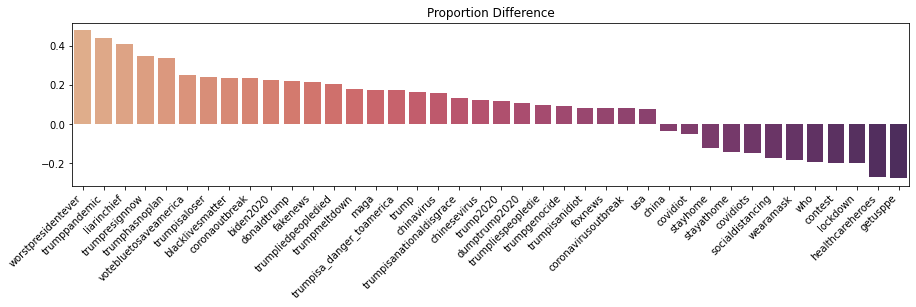

In [76]:
START_INDEX = 0
END_INDEX = 30
fig, ax = plt.subplots(figsize=(15, 3))

sns.barplot(x=[i[0] for i in pdiff_sorted], 
            y=[i[1] for i in pdiff_sorted], 
            orient='v', palette="flare", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Proportion Difference")
plt.show()


## Chi Test

In [46]:
hashtag_popless = pop_less(hashtag_dict)
rumor_hashtag_popless = pop_except_list(rumor_hashtag_dict, list(hashtag_proportion.keys()))
norumor_hashtag_popless = pop_except_list(norumor_hashtag_dict, list(hashtag_proportion.keys()))

assert len(list(rumor_hashtag_popless.keys())) == len(list(hashtag_popless.keys()))
assert len(list(norumor_hashtag_popless.keys())) == len(list(hashtag_popless.keys()))

In [64]:
CHI_THRESHOLD = 3.84
def freq_diff(dict1, dict2, alldict, threshold=CHI_THRESHOLD):
    rmdict_chi = defaultdict(float)
    nrdict_chi = defaultdict(float)
    
    rm_hashtag_sum = sum(list(dict1.values()))
    nr_hashtag_sum = sum(list(dict2.values()))
    hashtag_sum = sum(list(alldict.values()))
    assert rm_hashtag_sum+nr_hashtag_sum==hashtag_sum
    rm_e, nr_e = rm_hashtag_sum/hashtag_sum, nr_hashtag_sum/hashtag_sum
    for k in dict1.keys():
        diff = ((dict1[k]-rm_e*alldict[k])**2)/(rm_e*alldict[k]) + ((dict2[k]-nr_e*alldict[k])**2)/(nr_e*alldict[k])
        if diff>threshold:
            if dict1[k] > rm_e*alldict[k]:
                rmdict_chi[k]=diff
            else:
                nrdict_chi[k]=diff
    return rmdict_chi, nrdict_chi

In [69]:
rmdict_chi, nrdict_chi = freq_diff(rumor_hashtag_popless, norumor_hashtag_popless, hashtag_popless)
rmchi_sorted = [[item[0], item[1]] for item in sorted(rmdict_chi.items(), key=lambda item: item[1], reverse=True)] 
nrchi_sorted = [[item[0], item[1]] for item in sorted(nrdict_chi.items(), key=lambda item: item[1], reverse=True)] 

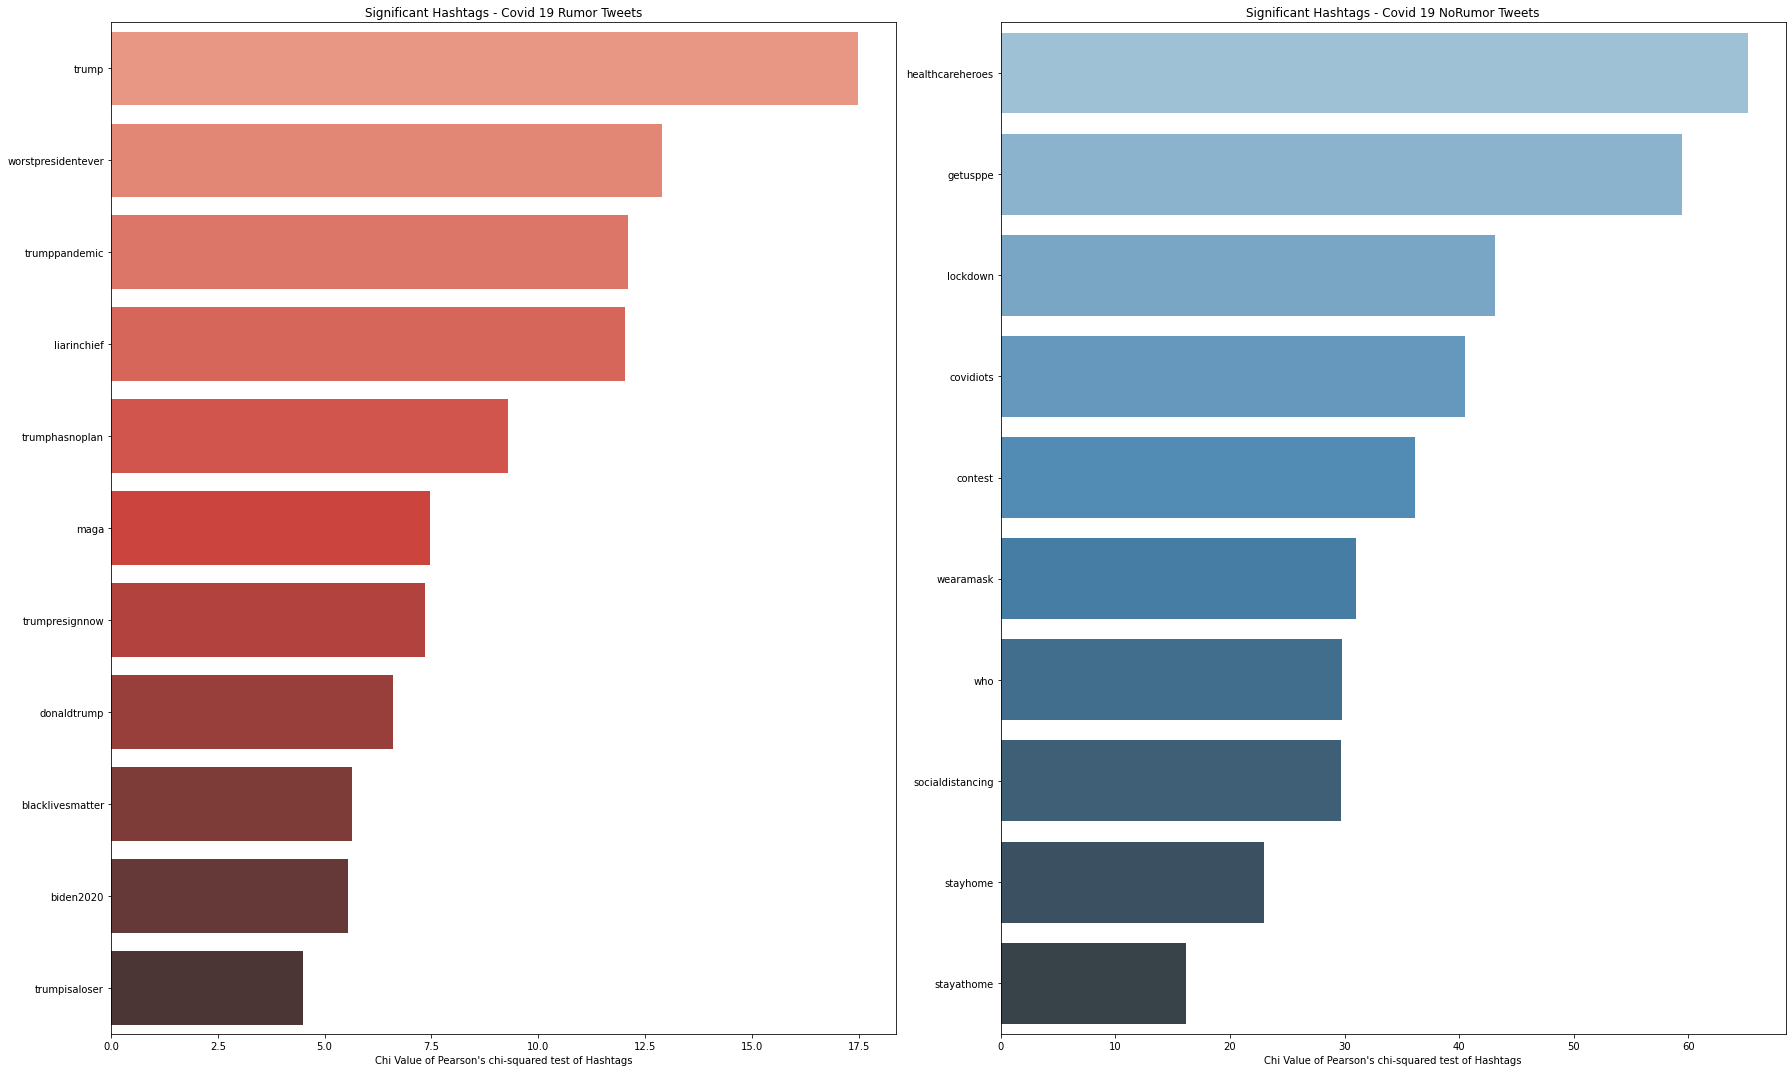

In [73]:
fig, ax = plt.subplots(1,2, figsize=(25,15))

sns.barplot(y=[i[0] for i in rmchi_sorted], x=[i[1] for i in rmchi_sorted], 
            orient='h', ax=ax[0], palette="Reds_d")

sns.barplot(y=[i[0] for i in nrchi_sorted], x=[i[1] for i in nrchi_sorted], 
            orient='h', ax=ax[1], palette="Blues_d")

ax[0].set_title(f"Significant Hashtags - Covid 19 Rumor Tweets")
ax[0].set_xlabel("Chi Value of Pearson's chi-squared test of Hashtags")
ax[1].set_title(f"Significant Hashtags - Covid 19 NoRumor Tweets")
ax[1].set_xlabel("Chi Value of Pearson's chi-squared test of Hashtags")
plt.tight_layout()
plt.show()

# 

[]

-1.255291487663731

65

135

200

0.015144454799627213